### Random forest

Here we train three random forests, one for each of the fire types. We feed them through an sklearn pipeline, save them and plot graphs of feature importance and ROC curves. There is also some investiagation of recall and precision. 

Maps are generated for 2017,2018 and 2019

In [1]:
#Modelling tools contains custom functions
import Modelling_tools as MT
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#This will be useful for assessing the model performance
from sklearn import metrics

In [3]:
#For saving the final models
import pickle

In [4]:
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

### Load the assembled dataset (see codes for dataset assembly)

In [5]:
dataset = pd.read_csv("/Users/rmartinshort/Documents/Insight/Project/census_block_prediction/Fully_merged_dataset_Autogenerated_plus.csv")

In [6]:
#Do something about the NaNs (~10% of dataset)
#Where we don't have information about the property, fill
#unknownusetype and set proportions of use types to zero
#Then set the remaining Na values to be the mean 

#In practice the model output does not change much no matter
#what we value we choose to fill them with. Its also possible to train
#a model without NaNs, but then we end up with missing blocks
#in the web app 

dataset['UnkownUseType'].fillna(1,inplace=True)
dataset['S'].fillna(1,inplace=True)
values = {'COMH':0, 'COMM':0, 'COMO':0, 'COMR':0, 'GOVT':0, 'IND':0, 'MISC':0,
       'MRES':0, 'SRES':0, 'A':0, 'B':0, 'C':0, 'D':0}
dataset = dataset.fillna(value=values)
dataset.fillna(dataset.mean(),inplace=True)

In [7]:
dataset.drop(['IDyear_x.1'],inplace=True,axis=1)

In [8]:
#drop columns related to sensitive demographic data 
dataset.drop(['H7X002', 'H7X003', 'H7X004', 'H7X005', 'H7X006', 'H7X007', 'H7X008'],inplace=True,axis=1)

In [9]:
#Parameters for grid search. These were refined from a much larger set
test_parameters_RF = {
        'classify__n_estimators': (100,200),
        'classify__max_depth': (8,15),
        'classify__min_samples_split':(8,15),
        'classify__min_samples_leaf':(10,20,30),
        'classify__class_weight':('balanced','balanced_subsample')
}

### External fires, 2018

In [10]:
X,y,Xholdout,yholdoutEF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='EF_pred',yearto_holdout=2018)

In [11]:
#Load the map geometry data. We need to make sure that the cell IDs are in correct order
GISCELLS = list(holdout['GISYEARJOIN'])
SF_blocks_years = gpd.read_file('SF_block_years_2010.shp')
mapdata = SF_blocks_years[SF_blocks_years['GISYEARJOI'].isin(GISCELLS)]

In [14]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True,
                                                          scoring_method='roc_auc')

In [15]:
#Run grid search for the best model
Xcols_EF, RC_model_EF_2018 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (10, 20, 30), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 15.8min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 20.5min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1248.803s

Best score: 0.842
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 15
	classify__min_samples_leaf: 30
	classify__min_samples_split: 8
	classify__n_estimators: 200


In [16]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

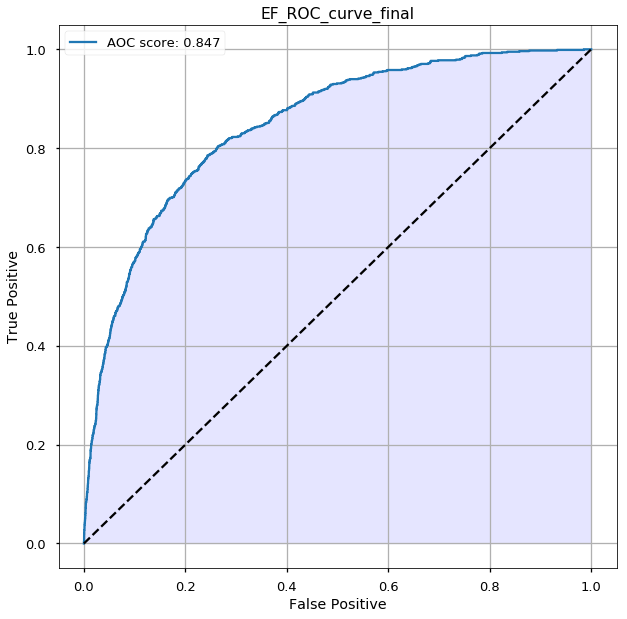

In [17]:
ROCplot, false_positive_EF, true_positive_EF, thresholds_EF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_EF_2018,
                                                                                title='EF_ROC_curve_final')

In [18]:
fprobs = RC_model_EF_2018.predict_proba(Xholdout)

In [19]:
fclass = RC_model_EF_2018.predict(Xholdout)

This is reasonable: With a theshold of 0.5 we catch the majority of the external fires, but we end up flagging too many cells, so the precision is low. We need to raise the threshold if we want to designate a useful proportion of the city

In [20]:
metrics.recall_score(yholdoutEF,fclass)

0.7487684729064039

In [21]:
metrics.precision_score(yholdoutEF,fclass)

0.30430430430430433

In [22]:
metrics.f1_score(yholdoutEF,fclass)

0.4327402135231317

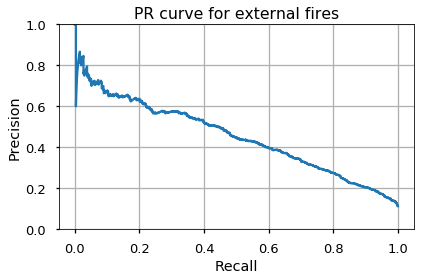

In [23]:
from sklearn.metrics import precision_recall_curve
precisionEF, recallEF, thresholds = precision_recall_curve(yholdoutEF,fprobs[:,1])
plt.plot(recallEF,precisionEF)
#plt.plot(recallVF,precisionVF)
#plt.plot(recallSF,precisionSF)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('PR curve for external fires')
plt.tight_layout()
plt.ylim([0.,1])
plt.savefig('PR_curve_external_fires.png',dpi=400)

These numbers are interesting and useful from a storytelling perspective: The model has high recall (flags the majority of blocks that will contain fires) but low precision (many of the blocks it flags don't have fires) at a threshold of 0.5. To combat this, we need to have some reasonable way of raising the threshold - and we can do this using the mean cell method

In [24]:
feature_importances = RC_model_EF_2018.named_steps['classify'].feature_importances_

In [25]:
inds = feature_importances.argsort()[::-1]

In [26]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_EF[index])

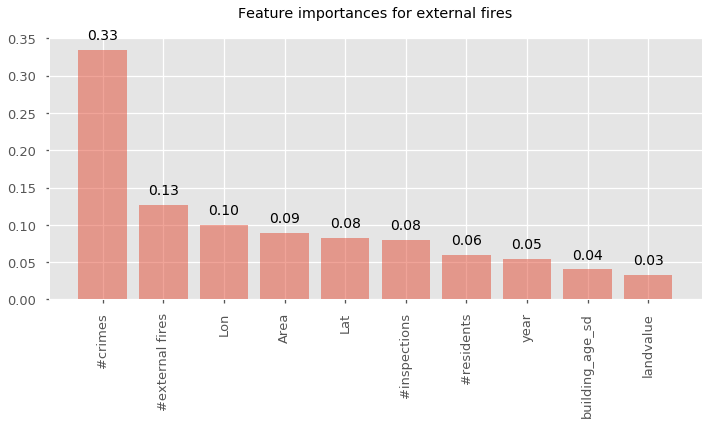

In [77]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals

#Better label names for plot
xlabels = ['#crimes','#external fires','Lon',
           'Area','Lat','#inspections','#residents',
           'year','building_age_sd','landvalue']

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for external fires",pad=20)
plt.tight_layout()
plt.savefig("External_fires_fimportance_final.png",dpi=400)

### Save the model!

In [28]:
filename = 'RC_model_EF_2018.sav'
pickle.dump(RC_model_EF_2018, open(filename, 'wb'))

### Function to generate map

In [29]:
def generate_foilum_map(riskmapdf,fires_df=None,firetype='structure',year='2018'):
    
    if firetype == 'external':
        HRzone = 'EFHR'
        Fprob = 'fprob_EF'
        Fid = 'EF'
        layer_name = 'External fires'
        output_name = 'external_'+year+'.html'
        
    elif firetype == 'vehicle':
        HRzone = 'VFHR'
        Fprob = 'fprob_VF'
        Fid = 'VF'
        layer_name = 'Vehicle fires'
        output_name = 'vehicle_'+year+'.html'
        
    elif firetype == 'structure':
        HRzone = 'SFHR'
        Fprob = 'fprob_SF'
        Fid = 'SF'
        layer_name = 'Structure fires'
        output_name = 'structure_'+year+'.html'
    
    
    riskmapdf['BLOCKID'] = np.arange(len(riskmapdf))
    gdf_wgs84 = riskmapdf.copy()
    gdf_wgs84.crs = {'init': 'epsg:4326', 'no_defs': True}


    m = folium.Map(location=[37.76, -122.42],zoom_start=13,
                   tiles="CartoDB positron",
                  width='100%',
                  height='100%')


    #Fill in the high risk zone layer
    folium.Choropleth(
        name = 'High risk zone',
        geo_data=gdf_wgs84[gdf_wgs84[HRzone]==1].to_json(),
        key_on = 'feature.properties.{}'.format('BLOCKID'),
        max_zoom=16,
        fill_opacity=0.5,
        fill_color='#ff0000',
        line_opacity=0.1,
        highlight=True,
        legend_name='High risk zone').add_to(m)

    #Fill in the risk score layer
    folium.Choropleth(
        show=False,
        name='Fire risk score',
        geo_data=gdf_wgs84.to_json(),data=riskmapdf,columns=['BLOCKID',Fprob],
        key_on = 'feature.properties.{}'.format('BLOCKID'),
        max_zoom=16,
        fill_opacity=0.8,
        fill_color='YlOrRd',
        line_opacity=0.1,
        highlight=True,
        legend_name='Fire risk score').add_to(m)
    
    if year != '2019':

        #Add the locations of actual fires
        coords = []
        popups = []
        icons = []
        for index, row in fires_df.iterrows():
            if row[Fid] == 1:
                lat = row['Lat']
                lon = row['Lon']
                popup = 'Fire at Lat: %.4f, Lon: %.4f' %(lat,lon)
                coords.append([lat,lon])
                popups.append(popup)
                icons.append(folium.Icon(color='white', 
                                      icon_color='red', 
                                      icon='fire', 
                                      angle=0,
                                      prefix='fa'))

        plt_lyr = folium.FeatureGroup(name = layer_name)

        plt_lyr.add_children(MarkerCluster(locations = coords, popups = popups,icons = icons, overlay=True))
        m.add_children(plt_lyr)

    m.add_child(folium.LatLngPopup())

    folium.LayerControl().add_to(m)

    m.save(output_name)

### Generate map for 2018 external fires

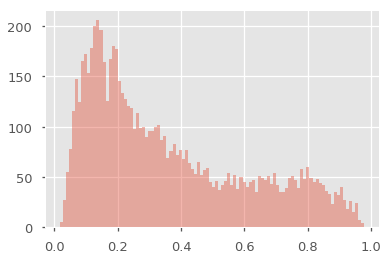

In [30]:
EF_2018_pred = RC_model_EF_2018.predict_proba(Xholdout)
#Plot the distribution of fire probabilities 
sns.distplot(EF_2018_pred[:,1],kde=False,bins=100)

In [31]:
fscoreEF = 10.0*EF_2018_pred[:,1] #put fscore on scale from zero to 10, but 
#don't normalize since this will result in information loss

In [32]:
#Find the thresholds for high risk zones
ncells_EF = 500 #number of blocks we choose to flag  
vallimEF = sorted(fscoreEF)[::-1][ncells_EF]
print(vallimEF)

8.147929884506055


In [33]:
fscoreEFHI = fscoreEF.copy()
fscoreEFHI[fscoreEFHI<=vallimEF]=0
fscoreEFHI[fscoreEFHI>vallimEF]=1

In [34]:
riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                                 'EFHR':fscoreEFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [35]:
fires_2018 = pd.read_csv("2018_fires.csv")

In [36]:
generate_foilum_map(riskmap_2018,fires_2018,firetype='external',year='2018')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


### Generate 2019 prediction for external fires

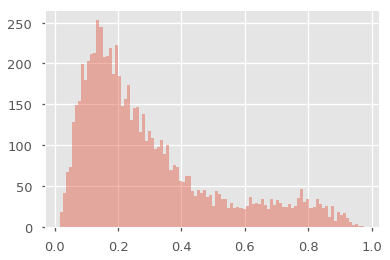

In [37]:
EF_2019_pred = RC_model_EF_2018.predict_proba(Xuseforfuture)
sns.distplot(EF_2019_pred[:,1],kde=False,bins=100)

In [38]:
fscoreEF = 10.0*EF_2019_pred[:,1] #put fscore on scale from zero to 10

In [39]:
#Find the thresholds for high risk zones
ncells_EF = 560 #number of blocks we choose to flag  
vallimEF = sorted(fscoreEF)[::-1][ncells_EF]
print(vallimEF)

7.180876965725361


In [40]:
fscoreEFHI = fscoreEF.copy()
fscoreEFHI[fscoreEFHI<=vallimEF]=0
fscoreEFHI[fscoreEFHI>vallimEF]=1

In [41]:
riskmap_2019 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                                 'EFHR':fscoreEFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [42]:
generate_foilum_map(riskmap_2019,firetype='external',year='2019')

### External fires, 2017

In [43]:
X,y,Xholdout,yholdoutEF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='EF_pred',yearto_holdout=2017)

In [44]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [45]:
#Run grid search for the best model
Xcols_EF, RC_model_EF_2017 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (10, 20, 30), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 12.7min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 16.8min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1025.722s

Best score: 0.842
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 15
	classify__min_samples_leaf: 30
	classify__min_samples_split: 15
	classify__n_estimators: 200


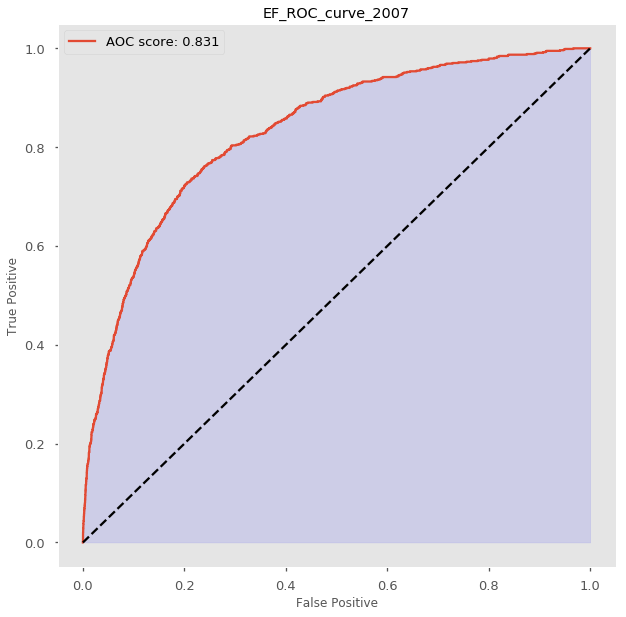

In [46]:
ROCplot, false_positive_EF, true_positive_EF, thresholds_EF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_EF_2017,
                                                                                title='EF_ROC_curve_2007')

In [47]:
fclass = RC_model_EF_2017.predict(Xholdout)
fprobs = RC_model_EF_2017.predict_proba(Xholdout)

In [48]:
metrics.recall_score(yholdoutEF,fclass)

0.7390180878552972

In [49]:
metrics.precision_score(yholdoutEF,fclass)

0.2848605577689243

In [50]:
metrics.f1_score(yholdoutEF,fclass)

0.41121495327102814

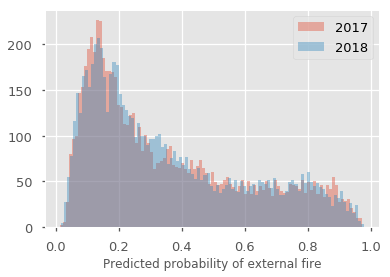

In [51]:
EF_2017_pred = RC_model_EF_2017.predict_proba(Xholdout)
#Plot the distribution of fire probabilities 
sns.distplot(EF_2017_pred[:,1],kde=False,bins=100,label='2017')
sns.distplot(EF_2018_pred[:,1],kde=False,bins=100,label='2018')
plt.legend(loc='best')
plt.xlabel('Predicted probability of external fire')
plt.savefig('Prob_dist_2017_vs_2018.png',dpi=300)

In [61]:
thresh = np.sort(EF_2018_pred[:,1])[::-1][560]

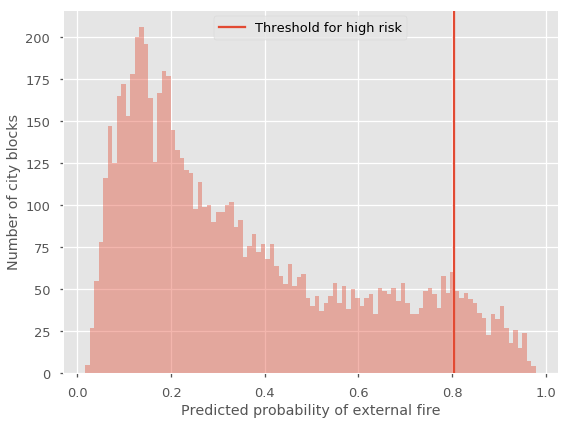

In [67]:
plt.style.use('seaborn-talk')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.distplot(EF_2018_pred[:,1],kde=False,bins=100,ax=ax)
ax.axvline(thresh,label='Threshold for high risk zone')
plt.legend(loc='best')
plt.xlabel('Predicted probability of external fire')
plt.ylabel('Number of city blocks')
plt.savefig('Prob_dist_external_2018_cutoff.png',dpi=300)
plt.tight_layout()

In [52]:
fscoreEF = 10.0*EF_2017_pred[:,1] #put fscore on scale from zero to 10

In [53]:
#Find the thresholds for high risk zones
ncells_EF = 560 #number of blocks we choose to flag  
vallimEF = sorted(fscoreEF)[::-1][ncells_EF]
print(vallimEF)

8.101104800280435


In [54]:
fscoreEFHI = fscoreEF.copy()
fscoreEFHI[fscoreEFHI<=vallimEF]=0
fscoreEFHI[fscoreEFHI>vallimEF]=1

In [55]:
riskmap_2017 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                                 'EFHR':fscoreEFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [56]:
fires_2017 = pd.read_csv("2017_fires.csv")

In [57]:
generate_foilum_map(riskmap_2017,fires_df=fires_2017,firetype='external',year='2017')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [53]:
filename = 'RC_model_EF_2017.sav'
pickle.dump(RC_model_EF_2017, open(filename, 'wb'))

### Vehicle fires, 2018

In [69]:
X,y,Xholdout,yholdoutVF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='VF_pred',yearto_holdout=2018)

In [70]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [71]:
#Run grid search for the best model
Xcols_VF, RC_model_VF_2018 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (10, 20, 30), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 15.6min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 20.6min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1245.537s

Best score: 0.764
Best parameters set:
	classify__class_weight: 'balanced'
	classify__max_depth: 8
	classify__min_samples_leaf: 20
	classify__min_samples_split: 15
	classify__n_estimators: 200


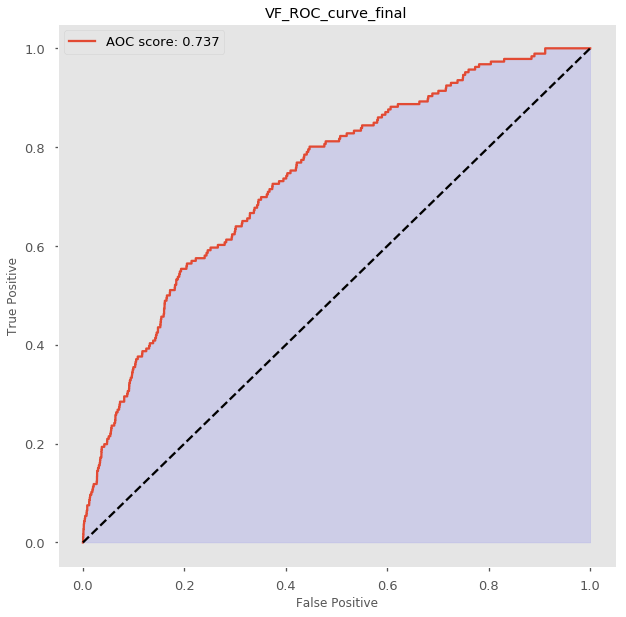

In [78]:
ROCplot, false_positive_VF, true_positive_VF, thresholds_VF = MT.plot_ROC_curve(Xholdout,yholdoutVF,RC_model_VF_2018,
                                                                               title='VF_ROC_curve_final')

In [79]:
fprobsvh = RC_model_VF_2018.predict_proba(Xholdout)
fclassvh = RC_model_VF_2018.predict(Xholdout)

These are the recall and precision scores for a threshold of 0.5. They're not great! But this is to be expected

In [80]:
metrics.recall_score(yholdoutVF,fclassvh)

0.5591397849462365

In [81]:
metrics.precision_score(yholdoutVF,fclassvh)

0.06653870761356366

In [82]:
feature_importances = RC_model_VF_2018.named_steps['classify'].feature_importances_

In [83]:
inds = feature_importances.argsort()[::-1]

In [84]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_VF[index])

['CrimeIsOther', 'LON', 'AREA', 'External_fire', 'LAT', 'Inspection Number', 'maxyr', 'sdyr', 'Assessed Land Value', 'Lot Area', 'Year Property Built', 'IDyear_x', 'Was complaint']
['#crimes', 'lon', 'area', '#external fires', 'lat', '#inspections', 'building_age_max', 'building_age_st', 'landvalue', 'meanlotarea', 'building_age_mean', 'year', '#complaints']


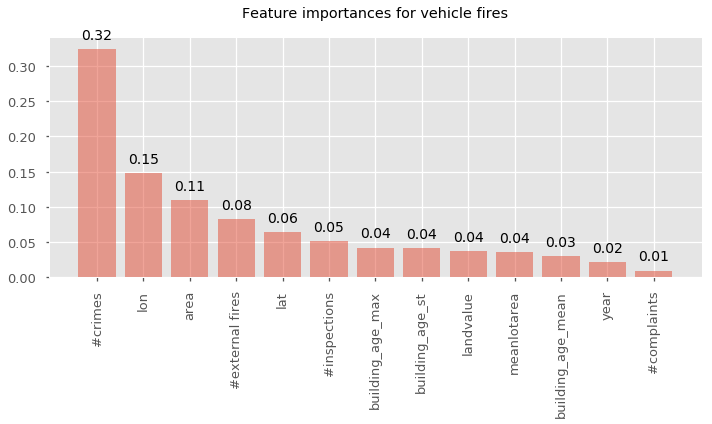

In [89]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals

xlabels=['#crimes','lon','area','#external fires','lat',
        '#inspections','building_age_max','building_age_st','landvalue',
        'meanlotarea','building_age_mean','year','#complaints']

print(fnames)
print(xlabels)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for vehicle fires",pad=20)
plt.tight_layout()
plt.savefig("Vehicle_fires_fimportance_final.png",dpi=400)

### Save the model!

In [90]:
filename = 'RC_model_VF_2018.sav'
pickle.dump(RC_model_VF_2018, open(filename, 'wb'))

### Generate map for 2018 vehicle fires

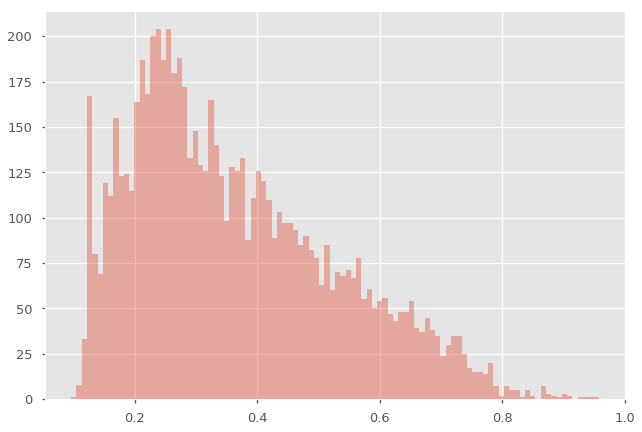

In [91]:
VF_2018_pred = RC_model_VF_2018.predict_proba(Xholdout)
#Plot the distribution of fire probabilities 
sns.distplot(VF_2018_pred[:,1],kde=False,bins=100)

In [92]:
fscoreVF = 10.0*VF_2018_pred[:,1] #put fscore on scale from zero to 10

In [93]:
#Find the thresholds for high risk zones
ncells_VF = 180 #number of blocks we choose to flag  
vallimVF = sorted(fscoreVF)[::-1][ncells_VF]
print(vallimVF)

7.2756440683665655


In [94]:
fscoreVFHI = fscoreVF.copy()
fscoreVFHI[fscoreVFHI<=vallimVF]=0
fscoreVFHI[fscoreVFHI>vallimVF]=1

In [95]:
riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_VF':fscoreVF,
                                 'VFHR':fscoreVFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [96]:
generate_foilum_map(riskmap_2018,fires_df=fires_2018,firetype='vehicle',year='2018')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


### Generate 2019 prediction for vehicle fires

6.579647996686378


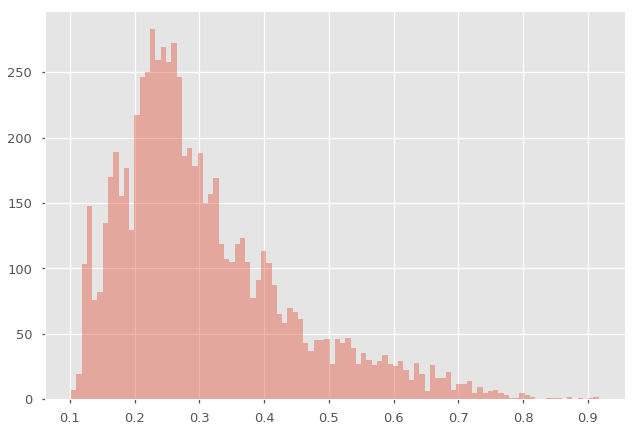

In [97]:
#Xuseforfuture must come from the 2018 holdout!!
VF_2019_pred = RC_model_VF_2018.predict_proba(Xuseforfuture)
sns.distplot(VF_2019_pred[:,1],kde=False,bins=100)
fscoreVF = 10.0*VF_2019_pred[:,1] #put fscore on scale from zero to 10

#Find the thresholds for high risk zones
ncells_VF = 180 #number of blocks we choose to flag  
vallimVF = sorted(fscoreVF)[::-1][ncells_VF]
print(vallimVF)

fscoreVFHI = fscoreVF.copy()
fscoreVFHI[fscoreVFHI<=vallimVF]=0
fscoreVFHI[fscoreVFHI>vallimVF]=1

riskmap_2019 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_VF':fscoreVF,
                                 'VFHR':fscoreVFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

generate_foilum_map(riskmap_2019,firetype='vehicle',year='2019')

### Vehicle fires, 2017

In [98]:
X,y,Xholdout,yholdoutVF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='VF_pred',yearto_holdout=2017)

In [99]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [100]:
#Run grid search for the best model
Xcols_VF, RC_model_VF_2017 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (10, 20, 30), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 16.0min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 964.840s

Best score: 0.766
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 8
	classify__min_samples_leaf: 30
	classify__min_samples_split: 8
	classify__n_estimators: 100


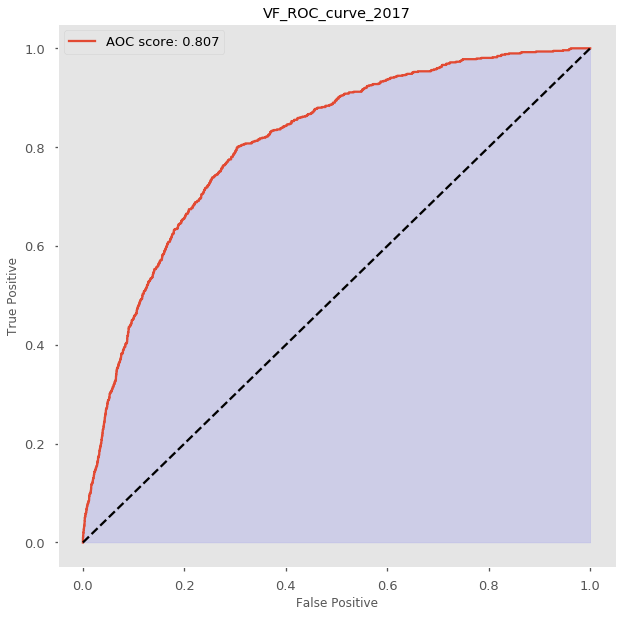

In [101]:
ROCplot, false_positive_VF, true_positive_VF, thresholds_VF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_VF_2017,
                                                                                title='VF_ROC_curve_2017')

In [102]:
fclass = RC_model_VF_2017.predict(Xholdout)
fprobs = RC_model_VF_2017.predict_proba(Xholdout)

In [103]:
metrics.recall_score(yholdoutVF,fclass)

0.586046511627907

In [104]:
metrics.precision_score(yholdoutVF,fclass)

0.07884856070087609

In [105]:
metrics.f1_score(yholdoutVF,fclass)

0.138996138996139

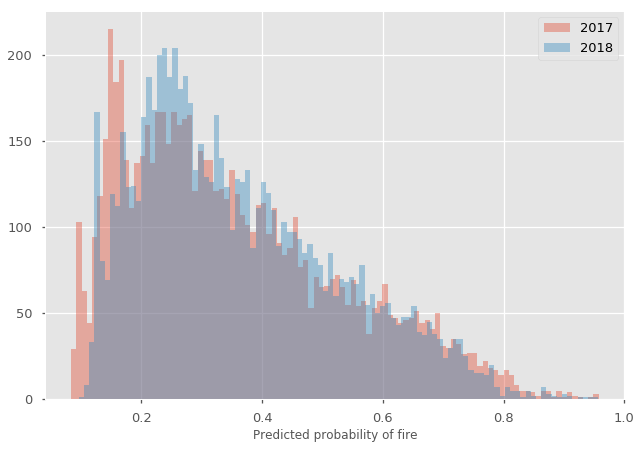

In [106]:
VF_2017_pred = RC_model_VF_2017.predict_proba(Xholdout)
#Plot the distribution of fire probabilities 
sns.distplot(VF_2017_pred[:,1],kde=False,bins=100,label='2017')
sns.distplot(VF_2018_pred[:,1],kde=False,bins=100,label='2018')
plt.legend(loc='best')
plt.xlabel('Predicted probability of fire')
plt.savefig('Prob_dist_2017_vs_2018_VF.png',dpi=300)

In [107]:
fscoreVF = 10.0*VF_2017_pred[:,1] #put fscore on scale from zero to 10

In [108]:
#Find the thresholds for high risk zones
ncells_VF = 180 #number of blocks we choose to flag  
vallimVF = sorted(fscoreVF)[::-1][ncells_VF]
print(vallimVF)

7.53569214865529


In [109]:
fscoreVFHI = fscoreVF.copy()
fscoreVFHI[fscoreVFHI<=vallimVF]=0
fscoreVFHI[fscoreVFHI>vallimVF]=1

In [110]:
riskmap_2017 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_VF':fscoreVF,
                                 'VFHR':fscoreVFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

In [111]:
fires_2017 = pd.read_csv("2017_fires.csv")

In [112]:
generate_foilum_map(riskmap_2017,fires_df=fires_2017,firetype='vehicle',year='2017')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [113]:
filename = 'RC_model_VF_2017.sav'
pickle.dump(RC_model_VF_2017, open(filename, 'wb'))

### Structure fires, 2018

In [114]:
X,y,Xholdout,yholdoutSF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='SF_pred',yearto_holdout=2018)

In [115]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [116]:
#Run grid search for the best model
Xcols_SF, RC_model_SF = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (10, 20, 30), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 13.4min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 17.7min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1074.710s

Best score: 0.807
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 8
	classify__min_samples_leaf: 20
	classify__min_samples_split: 15
	classify__n_estimators: 100


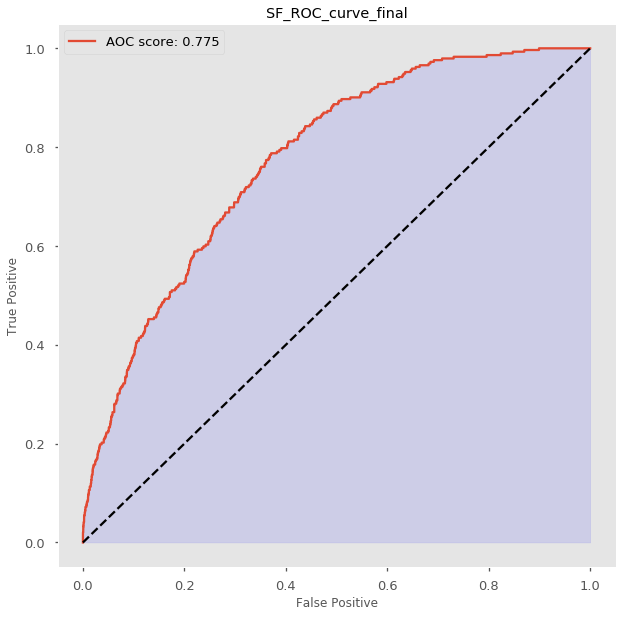

In [117]:
ROCplot, false_positive_SF, true_positive_SF, thresholds_VF = MT.plot_ROC_curve(Xholdout,yholdoutSF,RC_model_SF,
                                                                               title='SF_ROC_curve_final')

In [118]:
fprobssf = RC_model_SF.predict_proba(Xholdout)
fclasssf = RC_model_SF.predict(Xholdout)

These are the recall and precision scores for a threshold of 0.5. They're not great! But this is to be expected

In [119]:
metrics.recall_score(yholdoutSF,fclasssf)

0.5993150684931506

In [120]:
metrics.precision_score(yholdoutSF,fclasssf)

0.09449244060475162

In [121]:
feature_importances = RC_model_SF.named_steps['classify'].feature_importances_

In [122]:
inds = feature_importances.argsort()[::-1]

In [123]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_SF[index])

['#crimes', '#housingunits', '#nonfamilyhomes', '#pop', '#inspections', 'area', 'lon', 'lat', 'mean#units', 'building_age_mean', 'landvalue', 'meanlotarea', 'proportionres', 'year', '#complaints', '#structurefire'] ['CrimeIsOther', 'IFC001', 'H8C007', 'H7X001', 'Inspection Number', 'AREA', 'LON', 'LAT', 'Number of Units', 'Year Property Built', 'Assessed Land Value', 'Lot Area', 'MRES', 'IDyear_x', 'Was complaint', 'Structure_fire']
16 16


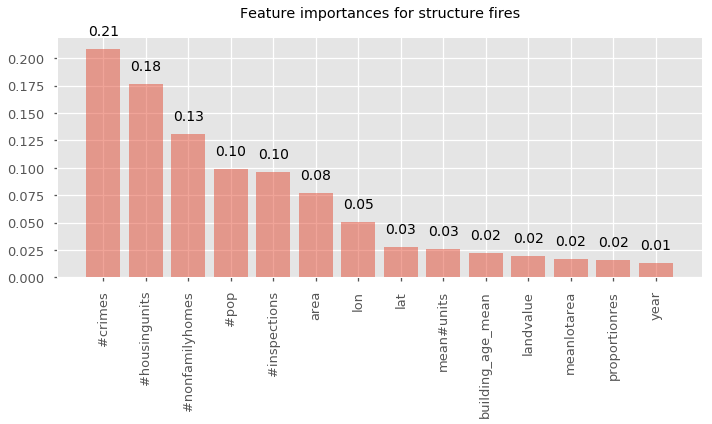

In [138]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals



xlabels = ['#crimes','#housingunits','#nonfamilyhomes','#pop','#inspections','area','lon','lat',
          'mean#units','building_age_mean','landvalue','meanlotarea','proportionres',
           'year','#complaints','#structurefire']


print(xlabels,fnames)
print(len(xlabels),len(fnames))
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels[:-2],ylabels[:-2],alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for structure fires",pad=20)
plt.tight_layout()
plt.savefig("Structure_fires_fimportance_final.png",dpi=400)

### Save the model

In [139]:
filename = 'RC_model_SF_2018.sav'
pickle.dump(RC_model_SF, open(filename, 'wb'))

### Generate 2019 prediction for strucure fires

7.2222906739297965


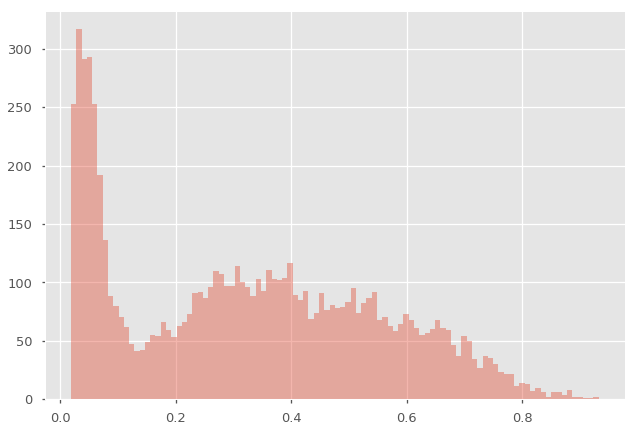

In [140]:
#Xuseforfuture must come from the 2018 holdout!!
SF_2019_pred = RC_model_SF.predict_proba(Xuseforfuture)
sns.distplot(SF_2019_pred[:,1],kde=False,bins=100)
fscoreSF = 10.0*SF_2019_pred[:,1] #put fscore on scale from zero to 10

#Find the thresholds for high risk zones
ncells_SF = 290  #number of blocks we choose to flag  
vallimSF = sorted(fscoreSF)[::-1][ncells_SF]
print(vallimSF)

fscoreSFHI = fscoreSF.copy()
fscoreSFHI[fscoreSFHI<=vallimSF]=0
fscoreSFHI[fscoreSFHI>vallimSF]=1

riskmap_2019 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_SF':fscoreSF,
                                 'SFHR':fscoreSFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

generate_foilum_map(riskmap_2019,firetype='structure',year='2019')

### Generate 2018 map for structure fires

In [141]:
SF_2018_pred = RC_model_SF.predict_proba(Xholdout)

fscoreSF = 10.0*SF_2018_pred[:,1] #put fscore on scale from zero to 10

#Find the thresholds for high risk zones
ncells_SF = 290 #number of blocks we choose to flag  
vallimSF = sorted(fscoreSF)[::-1][ncells_SF]
print(vallimSF)

fscoreSFHI = fscoreSF.copy()
fscoreSFHI[fscoreSFHI<=vallimSF]=0
fscoreSFHI[fscoreSFHI>vallimSF]=1

riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_SF':fscoreSF,
                                 'SFHR':fscoreSFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

generate_foilum_map(riskmap_2018,fires_df=fires_2018,firetype='structure',year='2018')

7.3354170074633265


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


### Structure fires, 2017

In [142]:
X,y,Xholdout,yholdoutSF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='SF_pred',yearto_holdout=2017)

pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

#Run grid search for the best model
Xcols_VF, RC_model_SF_2017 = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (100, 200), 'classify__max_depth': (8, 15), 'classify__min_samples_split': (8, 15), 'classify__min_samples_leaf': (10, 20, 30), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 14.2min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 18.4min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1119.709s

Best score: 0.812
Best parameters set:
	classify__class_weight: 'balanced'
	classify__max_depth: 8
	classify__min_samples_leaf: 30
	classify__min_samples_split: 15
	classify__n_estimators: 200


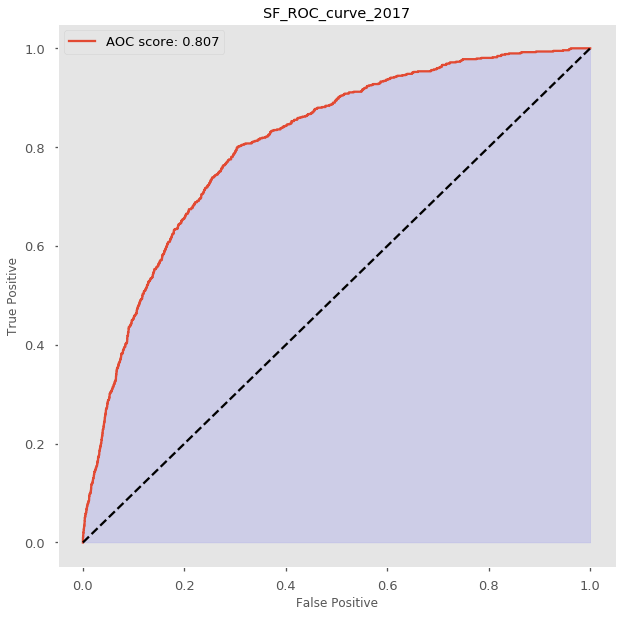

In [143]:
ROCplot, false_positive_SF, true_positive_SF, thresholds_SF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_VF_2017,
                                                                                title='SF_ROC_curve_2017')

In [144]:
SF_2017_pred = RC_model_SF_2017.predict_proba(Xholdout)
fscoreSF = 10.0*SF_2017_pred[:,1] #put fscore on scale from zero to 10

In [145]:
#Find the thresholds for high risk zones
ncells_SF = 290  #number of blocks we choose to flag  
vallimSF = sorted(fscoreSF)[::-1][ncells_SF]
print(vallimSF)

fscoreSFHI = fscoreSF.copy()
fscoreSFHI[fscoreSFHI<=vallimSF]=0
fscoreSFHI[fscoreSFHI>vallimSF]=1

riskmap_2017 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_SF':fscoreSF,
                                 'SFHR':fscoreSFHI,
                                 'GISYEARJOIN':mapdata['GISYEARJOI']})

generate_foilum_map(riskmap_2017,fires_df=fires_2017,firetype='structure',year='2017')

7.4943350746712545


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [146]:
filename = 'RC_model_SF_2017.sav'
pickle.dump(RC_model_SF, open(filename, 'wb'))

In [147]:
holdout.to_csv("2017_predictfires.csv",index=False)